 # A Deep Learning Approach to Predicting Cryptocurrency Prices (Ethereum, Bitcoin, etc.)
 
##### We will Implement a recurrent neural network to predict bitcoin prices

 

In [1]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error

#for logging
import time

##matrix math
import numpy as np
import math

##plotting
import matplotlib.pyplot as plt

##data processing
import pandas as pd

In [2]:
def load_data(filename, sequence_length):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    X_train -- A tensor of shape (2400, 49, 35) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2400,) that will be inputed into the model to train it
    X_test -- A tensor of shape (267, 49, 35) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (267,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (267,) that represents the price of bitcoin the day before each Y_test value
    unnormalized_bases -- A tensor of shape (267,) that will be used to get the true prices from the normalized ones
    window_size -- An integer that represents how many days of X values the model can look at at once
    """
    #Read the data file
    raw_data = pd.read_excel(filename)
    raw_data = raw_data.iloc[:,1:].values
    #Change all zeros to the number before the zero occurs
    for x in range(0, raw_data.shape[0]):
        for y in range(0, raw_data.shape[1]):
            if(raw_data[x][y] == 0):
                raw_data[x][y] = raw_data[x-1][y]
    
    #Convert the file to a list
    data = raw_data.tolist()
    
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #Normalizing data by going through each window
    #Every value in the window is divided by the first value in the window, and then 1 is subtracted
    d0 = np.array(result)
    dr = np.zeros_like(d0)
    dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1
    
    #Keeping the unnormalized prices for Y_test
    #Useful when graphing bitcoin price over time later
    start = 2400
    end = int(dr.shape[0] + 1)
    unnormalized_bases = d0[start:end,0:1,2]
    
    #Splitting data set into training (First 90% of data points) and testing data (last 10% of data points)
    split_line = round(0.9 * dr.shape[0])
    training_data = dr[:int(split_line), :]
    
    #Shuffle the data
    np.random.shuffle(training_data)
    
    #Training Data
    X_train = training_data[:, :-1]
    Y_train = training_data[:, -1]
    Y_train = Y_train[:, 2]
    
    #Testing data
    X_test = dr[int(split_line):, :-1]
    Y_test = dr[int(split_line):, 49, :]
    Y_test = Y_test[:, 2]

    #Get the day before Y_test's price
    Y_daybefore = dr[int(split_line):, 48, :]
    Y_daybefore = Y_daybefore[:, 2]
    
    #Get window size and sequence length
    sequence_length = sequence_length
    window_size = sequence_length - 1 #because the last value is reserved as the y value
    
    return X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size

# Step 2 - Building the Model

- We'll use a 3layer RNN with  20% dropout at each layer to reduce overfitting to the training data. 
- This model will have 515,579 trainable parameters throughout all of its layers. 
- The model uses the AdamOptimizer as its optimization function.
- The loss function used in this model is mean squared error. 
- A linear activation function is used in this model to determine the output of each neuron in the model. The linear activation function is simply defined as f(x) = x.
- The model will use Keras's Sequential model with Bidirectional LSTM layers.


![alt text](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/rnn.jpg "Logo Title Text 1")
![alt text](https://docs.microsoft.com/en-us/azure/machine-learning/preview/media/scenario-tdsp-biomedical-recognition/lstm-cell.png "Logo Title Text 1")
![alt text](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/bidirectional-rnn.png "Logo Title Text 1")
![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png "Logo Title Text 1")


Bidirectional RNNs are based on the idea that the output at time t may not only depend on the previous elements in the sequence, but also future elements. For example, to predict a missing word in a sequence you want to look at both the left and the right context. Bidirectional RNNs are quite simple. They are just two RNNs stacked on top of each other. The output is then computed based on the hidden state of both RNNs.

In [3]:
def initialize_model(window_size, dropout_value, activation_function, loss_function, optimizer):
    """
    Initializes and creates the model to be used
    
    Arguments:
    window_size -- An integer that represents how many days of X_values the model can look at at once
    dropout_value -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
    #Create a Sequential model using Keras
    model = Sequential()

    #First recurrent layer with dropout
    model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
    model.add(Dropout(dropout_value))

    #Second recurrent layer with dropout
    model.add(Bidirectional(LSTM((window_size*2), return_sequences=True)))
    model.add(Dropout(dropout_value))

    #Third recurrent layer
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    #Output layer (returns the predicted value)
    model.add(Dense(units=1))
    
    #Set activation function
    model.add(Activation(activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model

# Step 3 - Training the Model

- The model will be fitted to the training dat with a batch_size of 1024. 
- Additionally, 100 epochs will be performed to give the model time to adjust its weights and biases to fit the training data.
- 5% of the training data will be used as the validation set.  
- The model will train by minimizing the loss (mean squared error) of its training data. -- - The validation set is useful when attempting to identify signs of overfitting. 
- If the validation loss begins to consistently and rapidly increase, the model has overfitted to the training data, and changes should be made to the model. 


In [4]:
# epochs=100, batch_size=1, verbose=2)
def fit_model(model, X_train, Y_train, batch_num, epochs, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2400, 49, 35) that represents the x values of the training data
    Y_train -- A tensor of shape (2400,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 1024
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
    #Record the time the model starts training
    start = time.time()

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, epochs=epochs, validation_split= val_split)

    #Get the time it took to train the model (in seconds)
    training_time = int(math.floor(time.time() - start))
    return model, training_time

# Step 4 - Testing the Model

- The models given x values of testing data & will predict normalized prices (y_predict)
- Then, both the predicted values and the real values will be unnormalized and stored in separate arrays. 
- The values are unnormalized by looping through the predicted and true values. 
- 1 is added to each value, and then the result is multiplied by a corresponding number in the unnormalized_bases array. 
- In other words, the unnormalization processs is the exact reverse of the normalization process
- Finally, a plot is created of the unnormalized real values and the unnormalized predicted values. 

In [5]:
def test_model(model, X_test, Y_test, unnormalized_bases):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (267, 49, 35) that represents the x values of the testing data
    Y_test -- A tensor of shape (267,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (267,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (267,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (267,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (267,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    y_predict = model.predict(X_test)

    #Create empty 2D arrays to store unnormalized values
    real_y_test = np.zeros_like(Y_test)
    real_y_predict = np.zeros_like(y_predict)

    #Fill the 2D arrays with the real value and the predicted value by reversing the normalization process
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        predict = y_predict[i]
        real_y_test[i] = (y+1)*unnormalized_bases[i]
        real_y_predict[i] = (predict+1)*unnormalized_bases[i]

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Price Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Price')
    plt.plot(real_y_test, color = 'red', label = 'Real Price')
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return y_predict, real_y_test, real_y_predict, fig

# Step 5 - Evaluating Change in Price

- Lets plot the model's predicted change in price each day against the real change in price daily
- The percent increases of the predicted values and the real values are calculated by subtracting the value from the day before from the predicted/real value then dividing the result by 1+the value from the day before. 
- The predicted change in price is stored in delta_predict, while the real change in price is stored in delta_real.
- These two tensors are then graphed together to visualize the difference between predicted and real change in price for bitcoin throughout the testing period. 
- The plot will represent the percent change in bitcoin price each day. 

In [6]:
def price_change(Y_daybefore, Y_test, y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    Y_daybefore -- A tensor of shape (267,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (267,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (267,) that represents the normalized y values of the model's predictions
    
    Returns:
    Y_daybefore -- A tensor of shape (267, 1) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (267, 1) that represents the normalized y values of the testing data
    delta_predict -- A tensor of shape (267, 1) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (267, 1) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    #Reshaping Y_daybefore and Y_test
    Y_daybefore = np.reshape(Y_daybefore, (-1, 1))
    Y_test = np.reshape(Y_test, (-1, 1))

    #The difference between each predicted value and the value from the day before
    delta_predict = (y_predict - Y_daybefore) / (1+Y_daybefore)

    #The difference between each true value and the value from the day before
    delta_real = (Y_test - Y_daybefore) / (1+Y_daybefore)

    #Plotting the predicted percent change versus the real percent change
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title("Percent Change in Bitcoin Price Per Day")
    plt.plot(delta_predict, color='green', label = 'Predicted Percent Change')
    plt.plot(delta_real, color='red', label = 'Real Percent Change')
    plt.ylabel("Percent Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    
    return Y_daybefore, Y_test, delta_predict, delta_real, fig

# Step 6 - Process the Percent Change in Price

- The percent change in price will be processsed such that an increase in price is represented by a 1, and a decrease/no change is represented by a 0. These binary values will be stored in arrays delta_predict_1_0 and delta_real_1_0. 

- This will be done by looping through the values of the real and predicted percent change arrays. If a value is greater than 0, a 1 is stored in a new array. Otherwise, a 0 is stored in the new array.

- This process is very useful to understand how well the model did, and can be used to gather statistics about the model's performance.

In [7]:
def binary_price(delta_predict, delta_real):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (267, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (267, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    delta_predict_1_0 = np.empty(delta_predict.shape)
    delta_real_1_0 = np.empty(delta_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(delta_predict.shape[0]):
        if delta_predict[i][0] > 0:
            delta_predict_1_0[i][0] = 1
        else:
            delta_predict_1_0[i][0] = 0
    for i in range(delta_real.shape[0]):
        if delta_real[i][0] > 0:
            delta_real_1_0[i][0] = 1
        else:
            delta_real_1_0[i][0] = 0    

    return delta_predict_1_0, delta_real_1_0

# 7 - Comparing Predictions and Real Data

The binary categories computed in the previous cell is now used to compare predicted and real data. It will be used to find the number of:
- True positives
- False positives
- True negatives
- False negatives
These can then be used to further calculate statistics of the model's performance. 

This will be done by looping through both binary arrays at once and getting the corresponding values. If the real value is a 1 and the predicted value is a 1, that index will be counted as a true positive. If the real value is a 1 and the predicted value is a 0, that index will be counted as a false negative. If the real value is a 0 and the predicted value is a 0, that index will be counted as a true negative. If the real value is a 0 and the predicted value is a 1, that index will be counted as a false positive.

In [8]:
def find_positives_negatives(delta_predict_1_0, delta_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(delta_real_1_0.shape[0]):
        real = delta_real_1_0[i][0]
        predicted = delta_predict_1_0[i][0]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

# 8 - Calculating Statistics

![alt text](https://www.researchgate.net/profile/Alexandros_Karatzoglou/publication/221515860/figure/fig1/AS:339586132791298@1457975051470/Figure-1-Mean-Squared-Error-formula-used-to-evaluate-the-user-model.ppm "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/qconrio-machinelearningforeveryone-150826200704-lva1-app6892/95/qcon-rio-machine-learning-for-everyone-51-638.jpg?cb=1440698161 "Logo Title Text 1")


Putting everything together and getting statistics about the model. Statistics being calculated include:
- Precision: How often the model gets a true positive compared to how often it returns a positive
- Recall: How often the model gets a true positive compared to how often it should have gotten a positive
- F1 Score: The weighted average of recall and precision
- Mean Squared Error: The average of the squares of the differences between predicted and real values

In [9]:
def calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test):
    """
    Calculate various statistics to assess performance
    
    Arguments:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    Y_test -- A tensor of shape (267, 1) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (267, 1) that represents the normalized y values of the model's predictions
    
    Returns:
    precision -- How often the model gets a true positive compared to how often it returns a positive
    recall -- How often the model gets a true positive compared to how often is hould have gotten a positive
    F1 -- The weighted average of recall and precision
    Mean Squared Error -- The average of the squares of the differences between predicted and real values
    """
    precision = float(true_pos) / (true_pos + false_pos)
    recall = float(true_pos) / (true_pos + false_neg)
    F1 = float(2 * precision * recall) / (precision + recall)
    #Get Mean Squared Error
    MSE = mean_squared_error(y_predict.flatten(), Y_test.flatten())

    return precision, recall, F1, MSE

# 9 - Putting It All Together

Applying all the methods defined above and analyzing results.

## Loading the Data

In [10]:
X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size = load_data("Bitcoin_2012-2021.xlsx", 50)
print( X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print( Y_test.shape)
print( Y_daybefore.shape)
print( unnormalized_bases.shape)
print( window_size)
# (2400, 49, 35)
# (2400,)
# (267, 49, 35)
# (267,)
# (267,)
# (267, 1)
# 49

(2588, 49, 4)
(2588,)
(288, 49, 4)
(288,)
(288,)
(476, 1)
49


## Initializing the Model

In [11]:
model = initialize_model(window_size, 0.2, 'linear', 'mse', 'adam')
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 49, 98)            21168     
_________________________________________________________________
dropout (Dropout)            (None, 49, 98)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 196)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense (Dense)                (None, 1)                 99        
_________________________________________________________________
activation (Activation)      (None, 1)                 0

## Training the Model

In [12]:
model, training_time = fit_model(model, X_train, Y_train, 1024, 100, .05)

#Print the training time
print ("Training time", training_time, "seconds")

Epoch 1/100
3/3 [==============================] - 22s 4s/step - loss: 0.4109 - val_loss: 0.1091
Epoch 2/100
3/3 [==============================] - 7s 2s/step - loss: 0.1677 - val_loss: 0.1078
Epoch 3/100
3/3 [==============================] - 8s 2s/step - loss: 0.1416 - val_loss: 0.0539
Epoch 4/100
3/3 [==============================] - 7s 2s/step - loss: 0.0850 - val_loss: 0.0417
Epoch 5/100
3/3 [==============================] - 8s 2s/step - loss: 0.0775 - val_loss: 0.0213
Epoch 6/100
3/3 [==============================] - 7s 2s/step - loss: 0.0564 - val_loss: 0.0166
Epoch 7/100
3/3 [==============================] - 8s 2s/step - loss: 0.0575 - val_loss: 0.0121
Epoch 8/100
3/3 [==============================] - ETA: 0s - loss: 0.049 - 7s 2s/step - loss: 0.0483 - val_loss: 0.0149
Epoch 9/100
3/3 [==============================] - 8s 2s/step - loss: 0.0402 - val_loss: 0.0120
Epoch 10/100
3/3 [==============================] - 7s 2s/step - loss: 0.0344 - val_loss: 0.0160
Epoch 11/100
3

## Testing the Model

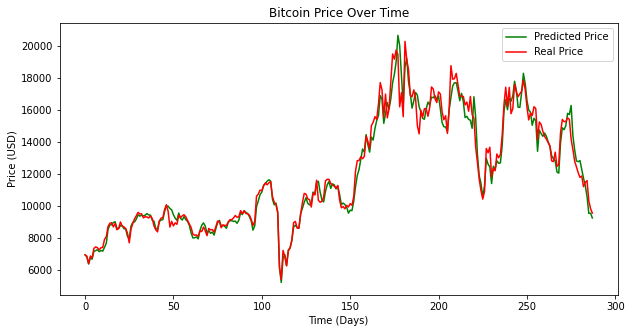

In [13]:
y_predict, real_y_test, real_y_predict, fig1 = test_model(model, X_test, Y_test, unnormalized_bases)

#Show the plot
plt.show(fig1)

In [14]:
fig1.savefig('C:/Users/User/Desktop/Esprit_Terminal/PFE2021/Présentation&Doc/data/BTCPredictedVSReal.png')

## Plotting Percent Change

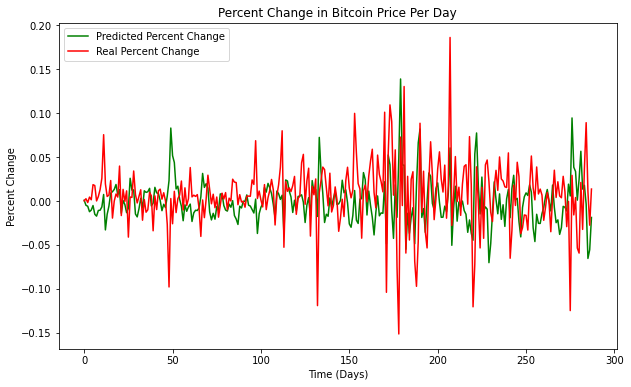

In [15]:
Y_daybefore, Y_test, delta_predict, delta_real, fig2 = price_change(Y_daybefore, Y_test, y_predict)

#Show the plot
plt.show(fig2)

In [16]:
len(delta_predict)

288

In [17]:
fig2.savefig('C:/Users/User/Desktop/Esprit_Terminal/PFE2021/Présentation&Doc/data/BTCPercentChange.png')

## Getting Binary Version of Percent Change

In [18]:
delta_predict_1_0, delta_real_1_0 = binary_price(delta_predict, delta_real)

print( delta_predict_1_0.shape)
print (delta_real_1_0.shape)

(288, 1)
(288, 1)


## Comparing Predictions and True Data

In [19]:
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(delta_predict_1_0, delta_real_1_0)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

True positives: 91
False positives: 36
True negatives: 56
False negatives: 105


## Getting the Statistics

In [20]:
precision, recall, F1, MSE = calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test)
print ("Precision:", precision)
print ("Recall:", recall)
print( "F1 score:", F1)
print ("Mean Squared Error:", MSE)

Precision: 0.7165354330708661
Recall: 0.4642857142857143
F1 score: 0.5634674922600619
Mean Squared Error: 0.004054017131988203


# Test Relative Strength Index Analysis

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from statistics import mean

In [22]:
df = pd.DataFrame()

In [23]:
df["Real Bitcoin Price"] = real_y_test
df["LSTM Bitcoin Price Predicted"] = real_y_predict

In [24]:
df['Average_Price'] = df.mean(axis=1)

In [25]:
df["Delta price change"] =delta_predict

In [26]:
# calculate gains/losses from previous day
df['Previous_Close_Price'] = df['LSTM Bitcoin Price Predicted'].shift(periods=-1)
df['Gain/Loss'] = df['LSTM Bitcoin Price Predicted'] - df['Previous_Close_Price']

In [27]:
# compute RSI
lookback_period = 14

rsi_list = []
for i, row in df.iterrows():
    try:
        sum_gain = sum([df.iloc[i + j]['Gain/Loss'] for j in range(lookback_period) if df.iloc[i + j]['Gain/Loss'] > 0])
        sum_loss = sum([-df.iloc[i + j]['Gain/Loss'] for j in range(lookback_period) if df.iloc[i + j]['Gain/Loss'] < 0])
        average_gain = sum_gain/lookback_period
        average_loss = sum_loss/lookback_period
        relative_strength = average_gain/average_loss
        rsi = 100 - (100/(1 + relative_strength))
    except IndexError:
        rsi = None
    rsi_list.append(rsi)

df['RSI'] = pd.Series(rsi_list)

# Defining our RSI backtesting strategy with Python
Now that we have calculated our RSI indicator for Apple for each of the days, we can merge them with the stockprices DataFrame. That will let us display all information into a single dataframe in order to define our strategy.

We will store the merged Pandas Dataframe in a variable named new (I know very original name). This will contain our original DataFrame plus the RSI indicator for each of the days.

Finally, we can start defining our strategy. The strategy will be included in the long column. If the RSI of the day is below 30 and we are crossing the 30 from below, we will have 1 in the column. The 1, will indicate that we are long in the stock. Otherwise, we will have a 0. Meaning that we are not holding the stock for that particular day.

We need three lines of code to ensure that our strategy is defined appropriately. E.g. 1 when we need to be long:

The first line of code on the long column, ensures that we will have a 1, if RSI is below 30.
The second line of code, ensures that we will have 0 if the RSI is above 70.
Then, finally, the third line of code, will ‘forward fill’ and propagate the last valid observation forward to get rid of the nan.
Above three lines will ensure that we only go long when we cross the line from below 30.

Finally, we calculate the gain and loss for each of the day and the accumulative return. Below screenshot shows that with this strategy, we would get an accumulative return of 50% if we followed the strategy during the last 5 years.

In [28]:
# new = pd.merge(data, RSI, left_index=True, right_index=True)

#If the indicator’s line crosses the level 30 from below, a long position (Buy) is opened.
df['long'] = np.where((df['RSI'] < 30),1,np.nan)
df['long'] = np.where((df['RSI'] > 70),0,df['long'])

df['long'].ffill(inplace=True)

# data['gain/loss'] = data['long'].shift(1) * data['return']

df['total'] =  df['Gain/Loss'].cumsum()

df.tail(100)

#outcome

,Real Bitcoin Price,LSTM Bitcoin Price Predicted,Average_Price,Delta price change,Previous_Close_Price,Gain/Loss,RSI,long,total
188,15022.610360,16932.849609,15977.729985,0.017634,16204.268555,728.581055,65.637556,1.0,-9267.405273
189,14509.203898,16204.268555,15356.736226,0.066134,15891.798828,312.469727,62.405704,1.0,-8954.935547
190,15988.946330,15891.798828,15940.372579,0.081842,15475.241211,416.557617,60.037638,1.0,-8538.377930
191,15567.294870,15475.241211,15521.268040,-0.018776,15428.259766,46.981445,59.002931,1.0,-8491.396484
192,16090.050825,15428.259766,15759.155295,-0.008666,16070.874023,-642.614258,45.108838,1.0,-9134.010742
193,16080.832256,16070.874023,16075.853140,-0.035722,16495.152344,-424.278320,44.096737,1.0,-9558.289062
194,15609.777145,16495.152344,16052.464745,0.000202,16307.287109,187.865234,42.017840,1.0,-9370.423828
195,16165.241268,16307.287109,16236.264189,0.031801,16805.250000,-497.962891,39.039859,1.0,-9868.386719
196,17446.542945,16805.250000,17125.896472,0.028146,16772.406250,32.843750,42.325697,1.0,-9835.542969
197,17320.567202,16772.406250,17046.486726,-0.002830,16891.033203,-118.626953,46.645194,1.0,-9954.169922


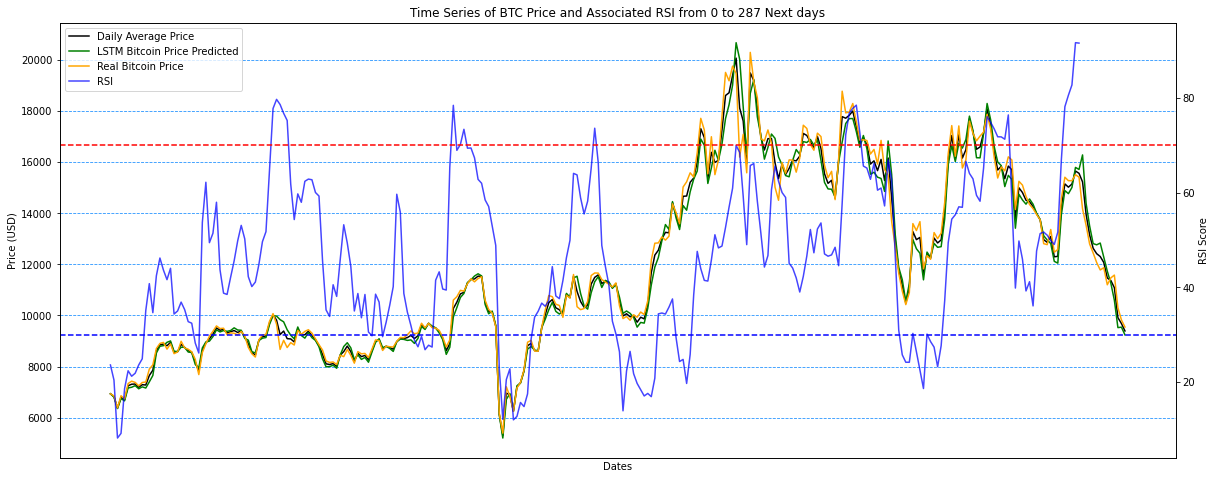

In [29]:
min_date = min(df.index)
max_date = max(df.index)

fig = plt.figure(figsize=(20,8))
plt.title(f'Time Series of BTC Price and Associated RSI from {min_date} to {max_date} Next days')
plt.xlabel('Dates')
plt.grid(color='dodgerblue', linestyle='--')

# plot price
ax = plt.gca()
ax.plot(df.index, df['Average_Price'], color='black', label='Daily Average Price')
ax.plot(df.index, df['LSTM Bitcoin Price Predicted'], color='Green', label='LSTM Bitcoin Price Predicted')
ax.plot(df.index, df['Real Bitcoin Price'], color='orange', label='Real Bitcoin Price')
ax.set_ylabel(f'Price (USD)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))

# plot RCI
ax2 = ax.twinx()
ax2.plot(df.index, df['RSI'], color='Blue', alpha=70, label='RSI')
ax2.set_ylabel('RSI Score')
ax2.axhline(y=70, color='r', linestyle='--')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))

# create legend
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)
plt.legend(handles=handles, labels=labels, loc='upper left')
# plt.plot(bsTrain)
# plt.plot(bstest)
plt.show()

In [30]:
import pickle
filename = 'C:/Users/User/Desktop/Esprit_Terminal/MyPycharmWork/PredictRSI.pkl'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()


# Test Models against new data
- file name EthereumOHCL_2014-2021.xlsx

In [31]:

X_train2, Y_train2, X_test2, Y_test2, Y_daybefore2, unnormalized_bases2, window_size2 = load_data("EthereumOHCL_2014-2021.xlsx", 50)
print( X_train2.shape)
print (Y_train2.shape)
print (X_test2.shape)
print( Y_test2.shape)
print( Y_daybefore2.shape)
print( unnormalized_bases2.shape)
print( window_size2)
# (2400, 49, 35)

(1840, 49, 4)
(1840,)
(205, 49, 4)
(205,)
(205,)
(0, 1)
49


In [33]:
model2 = initialize_model(window_size2, 0.2, 'linear', 'mse', 'adam')
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 49, 98)            21168     
_________________________________________________________________
dropout_2 (Dropout)          (None, 49, 98)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 196)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 99        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

In [34]:
model2, training_time2 = fit_model(model2, X_train2, Y_train2, 1024, 100, .05)

#Print the training time
print ("Training time", training_time2, "seconds")

Epoch 1/100
2/2 [==============================] - 21s 5s/step - loss: 1.4216 - val_loss: 0.8199
Epoch 2/100
2/2 [==============================] - 5s 2s/step - loss: 0.7301 - val_loss: 0.4387
Epoch 3/100
2/2 [==============================] - 6s 3s/step - loss: 0.4401 - val_loss: 0.4253
Epoch 4/100
2/2 [==============================] - 6s 3s/step - loss: 0.4866 - val_loss: 0.3155
Epoch 5/100
2/2 [==============================] - 6s 2s/step - loss: 0.3230 - val_loss: 0.2390
Epoch 6/100
2/2 [==============================] - 6s 3s/step - loss: 0.2711 - val_loss: 0.2094
Epoch 7/100
2/2 [==============================] - 6s 3s/step - loss: 0.2199 - val_loss: 0.1475
Epoch 8/100
2/2 [==============================] - 6s 2s/step - loss: 0.1637 - val_loss: 0.1238
Epoch 9/100
2/2 [==============================] - 6s 3s/step - loss: 0.1550 - val_loss: 0.1211
Epoch 10/100
2/2 [==============================] - 6s 3s/step - loss: 0.1545 - val_loss: 0.1165
Epoch 11/100
2/2 [====================

In [38]:
y_predict2, real_y_test2, real_y_predict2, fig2 = test_model(model2, X_test2, Y_test2, unnormalized_bases2)

#Show the plot
plt.show(fig2)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
fig2.savefig('C:/Users/User/Desktop/Esprit_Terminal/PFE2021/Présentation&Doc/data/ETHPredictedVSReal.png')

In [ ]:
Y_daybefore2, Y_test2, delta_predict2, delta_real2, fig3 = price_change(Y_daybefore2, Y_test2, y_predict2)

#Show the plot
plt.show(fig3)
fig3.savefig('C:/Users/User/Desktop/Esprit_Terminal/PFE2021/Présentation&Doc/data/ETHPercentChange.png')

In [ ]:
delta_predict_1_0, delta_real_1_0 = binary_price(delta_predict2, delta_real2)

print( delta_predict_1_0.shape)
print (delta_real_1_0.shape)

In [ ]:
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(delta_predict_1_0, delta_real_1_0)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

In [ ]:
precision, recall, F1, MSE = calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict2, Y_test2)
print ("Precision:", precision)
print ("Recall:", recall)
print( "F1 score:", F1)
print ("Mean Squared Error:", MSE)

In [ ]:
df2 = pd.DataFrame()
df2["Real ETH Price"] = real_y_test2
df2["LSTM ETH Price Predicted"] = real_y_predict2
df2['Average_Price'] = df2.mean(axis=1)
df2["Delta price change"] =delta_predict2
# calculate gains/losses from previous day
df2['Previous_Close_Price'] = df2['LSTM ETH Price Predicted'].shift(periods=-1)
df2['Gain/Loss'] = df2['LSTM ETH Price Predicted'] - df2['Previous_Close_Price']

In [ ]:
# compute RSI
lookback_period = 14

rsi_list = []
for i, row in df2.iterrows():
    try:
        sum_gain = sum([df2.iloc[i + j]['Gain/Loss'] for j in range(lookback_period) if df2.iloc[i + j]['Gain/Loss'] > 0])
        sum_loss = sum([-df2.iloc[i + j]['Gain/Loss'] for j in range(lookback_period) if df2.iloc[i + j]['Gain/Loss'] < 0])
        average_gain = sum_gain/lookback_period
        average_loss = sum_loss/lookback_period
        relative_strength = average_gain/average_loss
        rsi = 100 - (100/(1 + relative_strength))
    except IndexError:
        rsi = None
    rsi_list.append(rsi)

df2['RSI'] = pd.Series(rsi_list)

In [ ]:
# new = pd.merge(data, RSI, left_index=True, right_index=True)

#If the indicator’s line crosses the level 30 from below, a long position (Buy) is opened.
df2['long'] = np.where((df2['RSI'] < 30),1,np.nan)
df2['long'] = np.where((df2['RSI'] > 70),0,df2['long'])

df2['long'].ffill(inplace=True)

# data['gain/loss'] = data['long'].shift(1) * data['return']

df2['total'] =  df2['Gain/Loss'].cumsum()

df2.tail(100)


In [ ]:
min_date = min(df2.index)
max_date = max(df2.index)

fig = plt.figure(figsize=(20,8))
plt.title(f'Time Series of BTC Price and Associated RSI from {min_date} to {max_date} Next days')
plt.xlabel('Dates')
plt.grid(color='dodgerblue', linestyle='--')

# plot price
ax = plt.gca()
ax.plot(df.index, df2['Average_Price'], color='black', label='Daily Average Price')
ax.plot(df.index, df2['LSTM ETH Price Predicted'], color='Green', label='LSTM ETH Price Predicted')
ax.plot(df.index, df2['Real ETH Price'], color='orange', label='Real ETH Price')
ax.set_ylabel(f'Price (USD)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))

# plot RCI
ax2 = ax.twinx()
ax2.plot(df2.index, df2['RSI'], color='Blue', alpha=70, label='RSI')
ax2.set_ylabel('RSI Score')
ax2.axhline(y=70, color='r', linestyle='--')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))

# create legend
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)
plt.legend(handles=handles, labels=labels, loc='upper left')
# plt.plot(bsTrain)
# plt.plot(bstest)
plt.show()